## Intro

This is a project I worked on a few months ago as I was learning about NLP and found myself with a digital copy of all the Shakespeare's plays.

There is some controversy around Shakespeare and whether he actually was the author of all the work it's been attributed to him. Despite this the experts do agree on a classification of the plays into comedies and tragedies. Beside the fact that one has a happy ending and one doesn't the two genres do differ for language, themes and writing style.

So the objective of this analysis is to identify, if possible, a split of the plays using natural language processing and compare it to the traditional classification to see it's captured by it.

#### Required libraries

In [1]:
import nltk
import math
import re
import lda
import sklearn
import my_kmeans
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.cluster import KMeans
from ggplot import *

In [2]:
stopwords = nltk.corpus.stopwords.words('english')

## Pre-processing

Before doing any analysis we need to perform a few operations to make the text machine-usable, so we first tokenize it (which simply means create a list where every element is a unigram = single word) and then use a process called stemming to remove suffixes so that words with the same root/meaning have the same representation. After this we remove all the stop-words (words like 'and', 'you', 'auxiliary verbs'.. that are very common but don't give any real insight on the text). At the end we obtain a matrix representation of the collection where each document is represented by a vector or word frequencies.

#### Input Data

shakespeare.txt includes all Shakespeare's plays and poems. Each line of the file starts with the expression title@row_number:

>hamlet@56053	HAMLET	Words, words, words.
>
>hamlet@56081
>
>hamlet@56082	LORD POLONIUS	What is the matter, my lord?
>
>hamlet@56125
>
>hamlet@56126	HAMLET	Between who?
>
>hamlet@56146
>
>hamlet@56147	LORD POLONIUS	I mean, the matter that you read, my lord.

### Text normalization

- find all the titles as a unique list of title@ expressions and delete the histories (for now) and the poems
- split the text into a list of lines
- for each play create an element in _collection_, delete title@row_number and store as plain text

In [3]:
collection = {} # dictionary of raw texts

with open('../../Datastore/shakespeare.txt', 'r') as f:
	raw = f.read()
	titles = [t for t in set(re.findall(r'[a-z]+@{1}', raw))]

	histories = ['glossary@', 'various@', 'sonnets@', 'kinghenryvi@', 'kinghenryiv@', 
                 'venusandadonis@', 'rapeoflucrece@', 'loverscomplaint@', 'kingrichardiii@', 
                 'kingrichardii@', 'kingjohn@', 'kinghenryv@','kinghenryviii@']
	titles = [title for title in titles if title not in histories]

	lines = raw.splitlines()
	for t in titles:
		key = t[:-1]
		text = [re.sub(r'[a-z]+@{1}[0-9]+[ \t\n]+','', l) for l in lines if re.match(t+'[0-9]+', l)]
		collection[key] = ' '.join(text)

- Initialize the tokenizer (disregards punctuation signs) and a stemmer (Porter algorithm)

In [4]:
tokenizer = RegexpTokenizer(r'\w+')
st = nltk.stem.PorterStemmer()

Add glossary of victorian english words

In [5]:
with open('glossary.txt', 'r') as f:
	glossary = f.read()

glossary = tokenizer.tokenize(glossary)

In [6]:
tokens = {}
stemmed = {}
documents = {} # dictionary of normalized texts

for key in collection.keys():
	collection[key] = re.sub(r'\n?\n[A-Z]*\t|\n|\t', ' ', collection[key])
	tokens[key] = tokenizer.tokenize(collection[key]) # delete punctuation
	names = [w.lower() for w in set(tokens[key]) if w.isupper()]
	tokens[key] = [w for w in tokens[key] if w.lower() not in names]
	tokens[key] = [w.lower() for w in tokens[key] if w.lower() not in stopwords + glossary]
	stemmed[key] = [st.stem(w.lower()) for w in tokens[key]]
	documents[key] = ' '.join(stemmed[key])    

**Feature Extraction/Vectorization**: given a Vocabulary (list of unique words in the corpus) each play is represented as an array of frequencies

In [7]:
vectorizer = CountVectorizer()

In [8]:
tfidfTransf = TfidfTransformer()

CountVectorizer() requires as input a list of documents (raw text)

In [9]:
freq_matrix = vectorizer.fit_transform(list(documents.values())).toarray()
freq_matrix.shape

(27, 11959)

In [10]:
tfidf_matrix = tfidfTransf.fit_transform(freq_matrix)
tfidf_matrix.shape

(27, 11959)

### Latent Dirichlet Allocation

Latent Dirichlet Allocation is an unsupervised technique for topic modelling.
Given a collection of documents, and k probability distributions over a collection of words (which we're going to call topic) LDA describe the statistical relationship between random variables that specifies a probabilistic procedure to generate topics, and documents. In this prospective LDA is a generative model, that is it describes how document obtains its words.

LDA describes documents generation as a 3 step process:
1. for each document draw a topic distribution
2. for each word in a document
1. draw a specific topic
2. draw a word from the multinomial probability conditioned on the topic

We can graphically display these model:
alpha and beta are corpus level parameters, where alpha is the parameter for the dirichlet distribution describing the topics within documents and beta is a metrics of word probabilities in a topic. This parameters are only selected once in the process of generating the corpus.
then the outher box represent documents, with theta being a document-level parameter sampled once per each document.
And the inner plate represents the repeated choice of topics and words within a document, where topics and words (z and w) are selected once per each word in each document.


what we are most interested in for this analysis is the dirichlet distribution. This because it can be used to model the randomness of probability mass functions.
A probability mass function gives the probability of a discrete variable to take a specific value x. A simple example of pmf is a 6-sided dice. If we have a bag full of dices and we randomly extract one we are effectively drawing from a random pmf. This can be modelled with a Dir. Of parameter alpha.
In the text example, a document is a collection of words and therefore can be regarded as a multinomial, so if x is a multinomial of parameters n and q, the dirichlet serves as a prior for the parameter q, where Qi positive and the sum of them equals 1.
In LDA topics are latent multinomials so we can use the dirichlet distribution to describe the probability of each topic in each document.

In [11]:
titles = np.array(documents.keys())
labels = np.array(['tragedy','comedy','comedy', 'tragedy','tragedy','tragedy','tragedy', 
                           'tragedy','comedy','comedy','comedy', 'comedy','tragedy','comedy', 
                           'tragedy', 'comedy', 'comedy','comedy', 'comedy', 'comedy','comedy', 
                           'comedy', 'tragedy', 'tragedy', 'comedy','comedy','comedy'])
year = np.array([1591, 1604, 1601, 1606, 1599, 1606, 1605, 1599, 1610, 1596, 1594, 1609, 
                 1605, 1598, 1607, 1600, 1603, 1610, 1590, 1599, 1600, 1595, 1604, 1592, 
                 1594, 1589, 1607])


In [12]:
lookup = []
for index in xrange(len(titles)):
    lookup.append( (titles[index], labels[index], year[index]))

lookup = np.array(lookup)
unique_words = vectorizer.get_feature_names()

Number of topics the dumb way: max likelihood

In [14]:
loglikelihoods = []
for k in [3, 6, 9, 18, 27, 36, 45, 54, 63, 72, 81, 90]:
    topic_model = lda.LDA(n_topics = k, n_iter = 500, random_state=23)
    topic_model.fit(freq_matrix)
    loglikelihoods.append(topic_model.loglikelihood())

In [15]:
tmp = pd.DataFrame({ 
        'num_topics': [3,6, 9, 18, 27, 36, 45, 54, 63, 72, 81, 90],
        'log_like': loglikelihoods})

/Users/serena/.virtualenvs/py/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


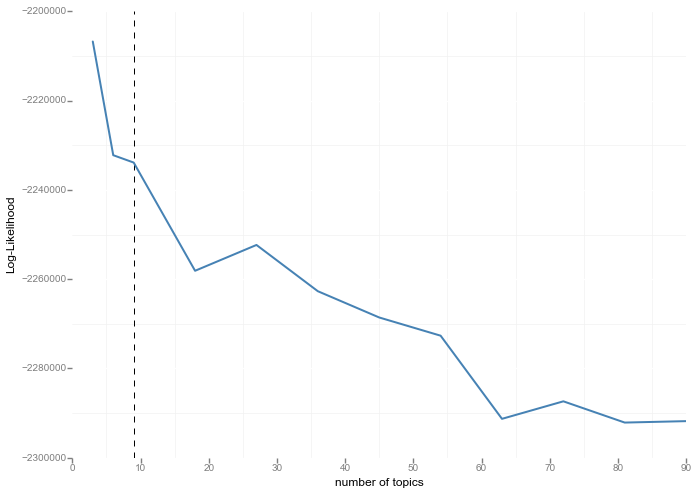

<ggplot: (279237349)>

In [16]:
%matplotlib inline
# plt.plot(range(2,28), loglikelihoods)
# plt.show()
ggplot(tmp, aes(x='num_topics', y='log_like')) + geom_line(color='steelblue', size=2) + xlab('number of topics') \
+ ylab('Log-Likelihood') + theme_bw() + geom_vline(xintercept=9, linetype='dashed')

In [35]:
num_of_topics = 9
topic_model = lda.LDA(n_topics= num_of_topics, n_iter=2000, random_state=123)
topic_model.fit(freq_matrix)

<lda.lda.LDA instance at 0x11696ff38>

In [36]:
topic_model.loglikelihood()

-2215120.957315091

As a result, we obtain 12 word distributions, which represent the topics (top 10 here) and, more interesting 27 12-dimentional distribution of topics within documents.

In [37]:
topic_word = topic_model.topic_word_

n_top_words = 10

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(unique_words)[np.argsort(topic_dist)][:-n_top_words:-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: rome first citizen nobl soldier second us enter roman
Topic 1: good enter man give upon come love time yet
Topic 2: son father king hand arm tear murder hast earth
Topic 3: lord first servant second like god sea men honour
Topic 4: love sweet fair god eye man wit call play
Topic 5: shall say well come would let know see one
Topic 6: sir ti call great lord honour must whose still
Topic 7: master come sir good wife husband well hous go
Topic 8: fool ladi would lord gentleman know clown may madam


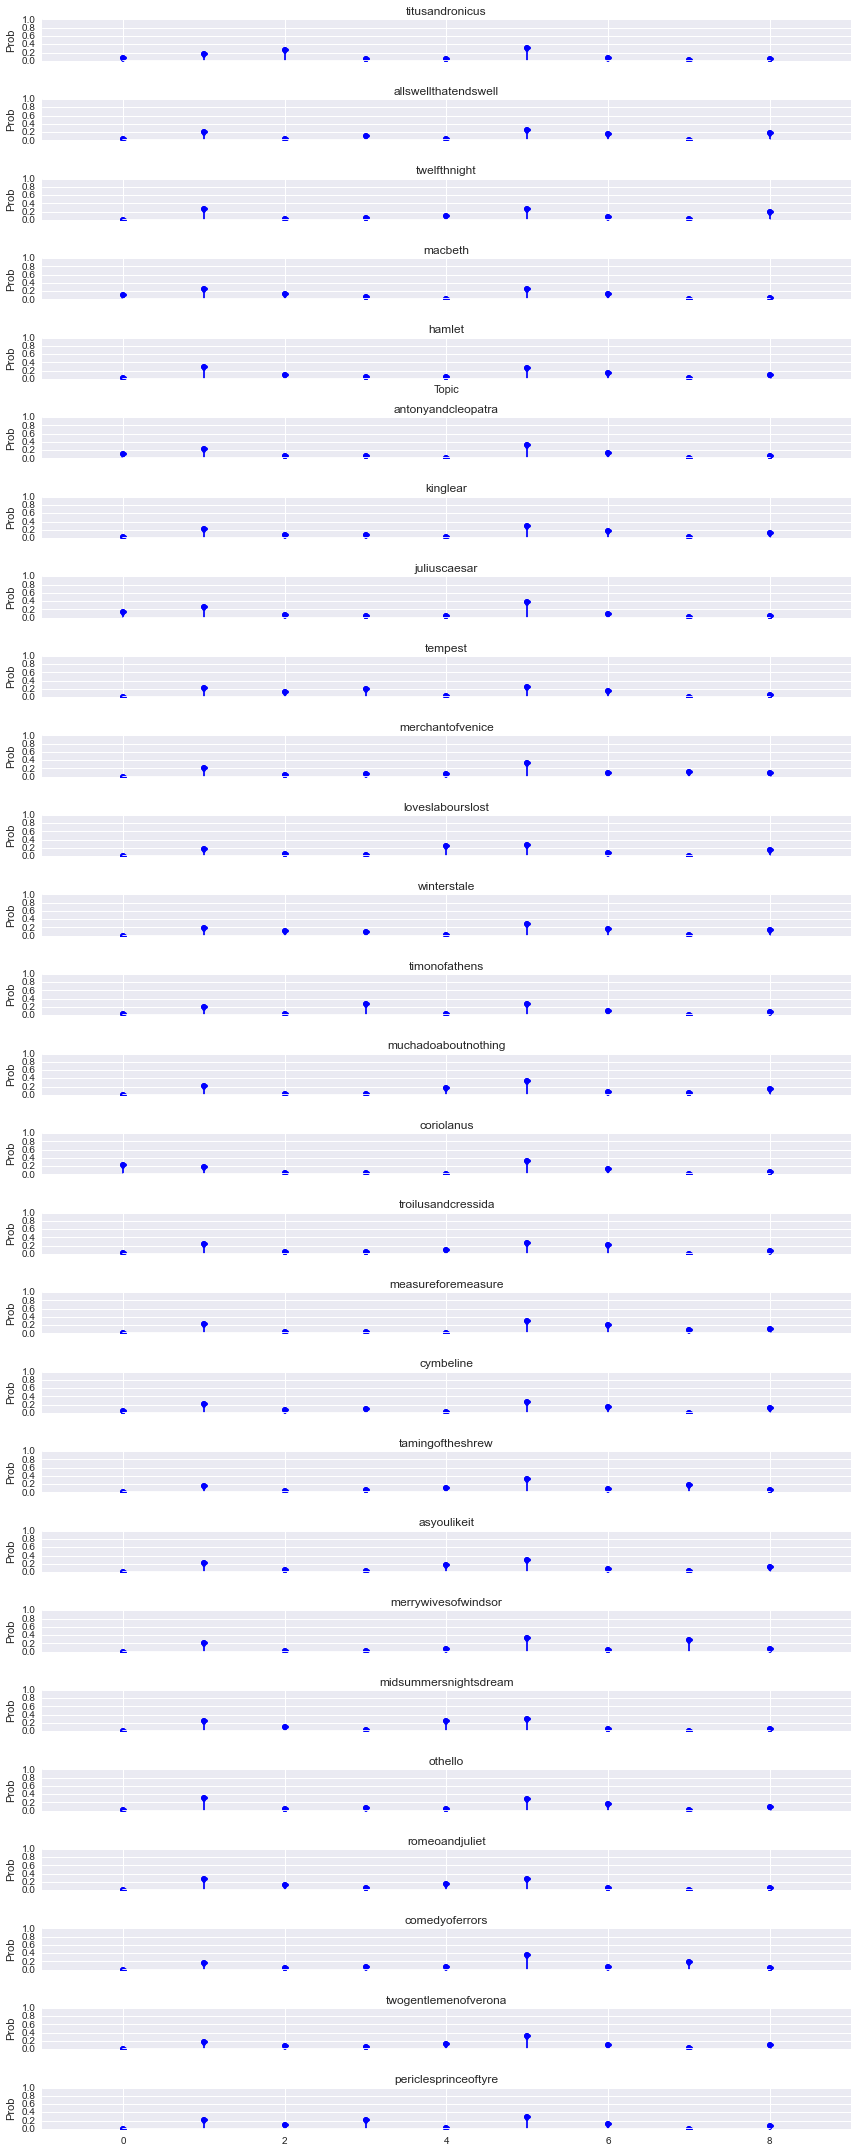

In [38]:
%matplotlib inline

doc_topic = topic_model.doc_topic_

f, ax= plt.subplots(27, 1, figsize=(12, 30), sharex=True)
for i, k in enumerate(titles):
    ax[i].stem(doc_topic[i,:], linefmt='b-',
               markerfmt='bo', basefmt='w-')
    ax[i].set_xlim(-1, num_of_topics)
    ax[i].set_ylim(0, 1)
    ax[i].set_ylabel("Prob")
    ax[i].set_title(k)

ax[4].set_xlabel("Topic")

plt.tight_layout()
plt.show()

In [39]:
np.savetxt("../plotly_sandbox/topics.csv", topic_model.doc_topic_, delimiter=",")

The distribution of topics over each document is used as input of the k-means. 

### K-Means

K means is an unsupervised clustering technique that creates a partition of the data such that every observation is assigned to the cluster with nearest mean. This guarantees minimal variability within observations in the same cluster and maximum variability between groups.

The results of this last step is a group almost entirely made of comedies, except for 'Romeo and Juliet' and a group that is almost evanly split between comedies and tragedies. So it looks like nlp doesn't capture the differences between comedies and tragedies.
However, experts do agree that Shakespeare's style has changed over the years.

In [41]:
km_topics = KMeans(n_clusters = 2, init = 'random', random_state = 15)
km_topics.fit(doc_topic)

KMeans(copy_x=True, init='random', max_iter=300, n_clusters=2, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=15, tol=0.0001,
    verbose=0)

In [42]:
km_topics.labels_

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1], dtype=int32)

In [43]:
lookup[ km_topics.labels_ == 0]

array([['twelfthnight', 'comedy', '1601'],
       ['merchantofvenice', 'comedy', '1596'],
       ['loveslabourslost', 'comedy', '1594'],
       ['muchadoaboutnothing', 'comedy', '1598'],
       ['tamingoftheshrew', 'comedy', '1590'],
       ['asyoulikeit', 'comedy', '1599'],
       ['merrywivesofwindsor', 'comedy', '1600'],
       ['midsummersnightsdream', 'comedy', '1595'],
       ['romeoandjuliet', 'tragedy', '1592'],
       ['comedyoferrors', 'comedy', '1594'],
       ['twogentlemenofverona', 'comedy', '1589']], 
      dtype='|S21')

In [44]:
lookup[km_topics.labels_ == 1]

array([['titusandronicus', 'tragedy', '1591'],
       ['allswellthatendswell', 'comedy', '1604'],
       ['macbeth', 'tragedy', '1606'],
       ['hamlet', 'tragedy', '1599'],
       ['antonyandcleopatra', 'tragedy', '1606'],
       ['kinglear', 'tragedy', '1605'],
       ['juliuscaesar', 'tragedy', '1599'],
       ['tempest', 'comedy', '1610'],
       ['winterstale', 'comedy', '1609'],
       ['timonofathens', 'tragedy', '1605'],
       ['coriolanus', 'tragedy', '1607'],
       ['troilusandcressida', 'comedy', '1600'],
       ['measureforemeasure', 'comedy', '1603'],
       ['cymbeline', 'comedy', '1610'],
       ['othello', 'tragedy', '1604'],
       ['periclesprinceoftyre', 'comedy', '1607']], 
      dtype='|S21')

In [45]:
lookup_df = pd.DataFrame({'title':titles, 'label':labels, 'year':year, 'cluster':km_topics.labels_})
groups = set(km_topics.labels_)

In [46]:
lookup_df.to_csv('../plotly_sandbox/lookup_titles.csv')

However, experts do agree that Shakespeare's style has changed over the years.

More specifically, they talk about an elizabethan Shakespeare, more influenced by the classics, and a more mature Shakespeare, writing under the reign of King James. So looking at the groups and the year the plays were written, group 1 includes only plays that were written before the death of elizabeth the first in 1603 and group 2 includes all the plays written for James the first (except for one)

In [22]:
%load_ext rmagic

/Users/serena/.virtualenvs/py/lib/python2.7/site-packages/IPython/extensions/rmagic.py:11: UserWarning: The rmagic extension in IPython has moved to `rpy2.ipython`, please see `rpy2` documentation.
  warnings.warn("The rmagic extension in IPython has moved to "


In [23]:
%Rpush lookup_df
%R boxplot(lookup_df$year ~ lookup_df$cluster, col = c('darkorchid4', 'darkorange')); abline(h = 1603, lty = 2)

ERROR: Line magic function `%Rpush` not found.
ERROR: Line magic function `%R` not found.


In [24]:
%R plot(x = titles$year, y = rep(1, nrow(titles)), pch = "*", cex = 3, col = ifelse(titles$cluster == 1, "steelblue", "seagreen"), xlab = "Year", ylab = "", yaxt = "n")

ERROR: Line magic function `%R` not found.


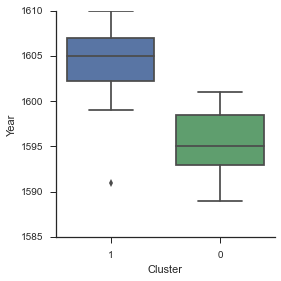

In [25]:
sns.set(style="ticks")

g = sns.factorplot(x = 'cluster', y = 'year', data = lookup_df, kind='box')
g.despine()
g.set_axis_labels('Cluster', 'Year')

### Conclusion

It was possible to create a two way split of shakespeare's works using nlp, the groups obtained this way don't reflect so much a difference in genre but rather a change in the style of Shakespeare's writing.

#### My own implementation of k-means

In [26]:
my_km_topics = my_kmeans.km(dat = doc_topic, k = 2, random_state = 8)

iteration 1


In [27]:
lookup[my_km_topics == 0]

array([['titusandronicus', 'tragedy', '1591'],
       ['allswellthatendswell', 'comedy', '1604'],
       ['macbeth', 'tragedy', '1606'],
       ['hamlet', 'tragedy', '1599'],
       ['antonyandcleopatra', 'tragedy', '1606'],
       ['kinglear', 'tragedy', '1605'],
       ['juliuscaesar', 'tragedy', '1599'],
       ['tempest', 'comedy', '1610'],
       ['winterstale', 'comedy', '1609'],
       ['timonofathens', 'tragedy', '1605'],
       ['coriolanus', 'tragedy', '1607'],
       ['troilusandcressida', 'comedy', '1600'],
       ['measureforemeasure', 'comedy', '1603'],
       ['cymbeline', 'comedy', '1610'],
       ['othello', 'tragedy', '1604'],
       ['periclesprinceoftyre', 'comedy', '1607']], 
      dtype='|S21')

In [28]:
lookup[my_km_topics == 1]

array([['twelfthnight', 'comedy', '1601'],
       ['merchantofvenice', 'comedy', '1596'],
       ['loveslabourslost', 'comedy', '1594'],
       ['muchadoaboutnothing', 'comedy', '1598'],
       ['tamingoftheshrew', 'comedy', '1590'],
       ['asyoulikeit', 'comedy', '1599'],
       ['merrywivesofwindsor', 'comedy', '1600'],
       ['midsummersnightsdream', 'comedy', '1595'],
       ['romeoandjuliet', 'tragedy', '1592'],
       ['comedyoferrors', 'comedy', '1594'],
       ['twogentlemenofverona', 'comedy', '1589']], 
      dtype='|S21')

In [29]:
lookup_df.to_csv('lookup.csv')